In [1]:
import numpy as np
from numpy import genfromtxt, savetxt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 5]

In [2]:
class Warburton_Simulator:
    def __init__(self,freqs,amps,timestep=0.0001,FWHM=1.25):
        self.freqs = freqs
        self.amplitudes = amps
        self.timestep = timestep
        self.time = 0.0
        self.FWHM = FWHM
        self.phases = np.random.uniform(0,2*np.pi,len(self.freqs))
        self.centers = []

    def step(self):
        center = 0.0
        for source in range(len(self.freqs)):
            center += self.amplitudes[source]*np.sin(2*np.pi*self.freqs[source]*self.time+self.phases[source])
        self.centers.append(center)
        self.time += self.timestep

    def run(self,time):
        num_steps = int(time/self.timestep)
        for step in range(num_steps):
            self.step()

In [3]:
QD_data = genfromtxt('Data/PowerSpectralDensity.csv', delimiter=',')
QD_data = QD_data[QD_data[:,0].argsort()]
QD_f_data = QD_data.T[0]
QD_p_data = QD_data.T[1]
QD_f_data_log = np.log(QD_f_data)
QD_p_data_log = np.log(QD_p_data)
QD_degrees = 15
QD_poly_fit_params = np.polyfit(QD_f_data_log,QD_p_data_log,QD_degrees)
def QD_poly_fit(f_log):
    p_log = 0
    for i in range(QD_degrees+1):
        p_log += QD_poly_fit_params[QD_degrees-i]*np.power(f_log,i)
    return p_log

In [4]:
LF_data = genfromtxt('Data/Nexp.csv', delimiter=',')
LF_data = LF_data[LF_data[:,0].argsort()]
LF_f_data = LF_data.T[0]
LF_p_data = LF_data.T[1]
LF_f_data_log = np.log(LF_f_data)
LF_p_data_log = np.log(LF_p_data)
LF_degrees = 1
LF_poly_fit_params = np.polyfit(LF_f_data_log,LF_p_data_log,LF_degrees)
def LF_poly_fit(f_log):
    p_log = 0
    for i in range(LF_degrees+1):
        p_log += LF_poly_fit_params[LF_degrees-i]*np.power(f_log,i)
    return p_log

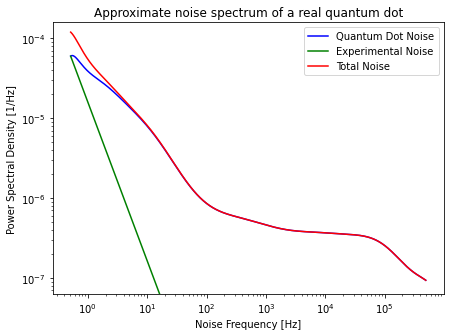

In [14]:
f_min = 0.51414021774167812 # Must be greater that 0.5414 Hz
f_max = 493318.9182771271 # Do not adjust
num_sources = 1000
f_vals_log = np.linspace(np.log(f_min),np.log(f_max),num_sources)
f_vals = np.exp(f_vals_log)
QD_p_vals_log = QD_poly_fit(f_vals_log)
QD_p_vals = np.exp(QD_p_vals_log)
LF_p_vals_log = LF_poly_fit(f_vals_log)
LF_p_vals = np.exp(LF_p_vals_log)
p_vals = QD_p_vals + LF_p_vals

plt.rcParams['figure.figsize'] = [7, 5]
plt.xscale("log")
plt.ylim([10**-7.2,10**-3.8])
plt.yscale("log")
plt.plot(f_vals,QD_p_vals,color='blue',label='Quantum Dot Noise')
plt.plot(f_vals,LF_p_vals,color='green',label='Experimental Noise')
plt.plot(f_vals,p_vals,color='red',label='Total Noise')
plt.title("Approximate noise spectrum of a real quantum dot")
plt.xlabel("Noise Frequency [Hz]")
plt.ylabel("Power Spectral Density [1/Hz]")
plt.legend()

In [13]:
N = 10000
integrals = np.zeros(N)
f_int = np.logspace(np.log(f_min),np.log(f_max),N,base=np.e)
f_int_log = np.log(f_int)
QD_p_int_log = QD_poly_fit(f_int_log)
LF_p_int_log = LF_poly_fit(f_int_log)
p_int = np.exp(QD_p_int_log) + np.exp(LF_p_int_log)

for i in range(N-1):
    m = np.log(p_int[i]/p_int[i+1])/np.log(f_int[i]/f_int[i+1])
    b = np.log(p_int[i]) - m*np.log(f_int[i])
    if (-1.0001 < m < -0.9999):
        integrals[i] = np.exp(b)*(np.log(f_int[i+1]/f_int[i]))
    else:
        integrals[i] = (np.exp(b)/(m+1))*(np.power(f_int[i+1],m+1)-np.power(f_int[i],m+1))
var = np.sum(integrals)
std = (np.sqrt(var))
print(std)

0.2941341376812333


In [8]:
coeffs = p_vals/p_vals[0]
p1 = 2*var/np.sum(coeffs)
powers = p1*coeffs
amps = np.sqrt(powers)
freqs = f_vals

## Raw Simulation

In [10]:
sim = Warburton_Simulator(freqs,amps,timestep=0.00005)
sim_time = 500

for i in range(10):
    sim.run(sim_time/10)
    val = str(10*(i+1))
    print(val + "% Complete")

data = np.array([sim.centers])[0]
savetxt('Data/AllNoiseSimulatedData.csv', data, delimiter=',')

10% Complete
20% Complete
30% Complete
40% Complete
50% Complete
60% Complete
70% Complete
80% Complete
90% Complete
100% Complete


In [11]:
print(len(data))

10000000


(-1.0, 1.0)

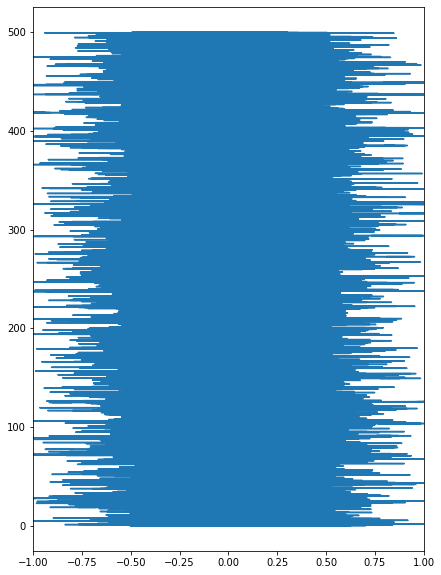

In [12]:
num = int(sim.time/sim.timestep)
times = np.linspace(0,sim.time,num)
length = len(times)
centers = sim.centers[0:length]
plt.rcParams['figure.figsize'] = [7, 10]
plt.plot(centers,times)
plt.xlim([-1,1])

## Laser Measurement Simulation

In [5]:
sim = Warburton_Simulator2(freqs,amps,timestep=0.0001)
f_1 = -0.5 # 1st laser frequency deviation [GHz]
f_2 = 0.5 # 2nd laser frequency deviation [GHz]
#f_3 = 0.5 # 3rd laser frequency deviation [GHz]
t_C = 0.05 # [s]
t_L = 0.002 # [s]
num_cycles = 100
L1_counts = np.zeros(num_cycles)
L2_counts = np.zeros(num_cycles)
#L3_counts = np.zeros(num_cycles)

tenth = int(num_cycles/10)
c = 0
for cycle in range(num_cycles):
    if cycle%tenth == 0:
        val = str(int(100*c/num_cycles))
        print(val + "% Complete")
        c += tenth
    L1_counts[cycle] = sim.measure(f_1,t_L)
    L2_counts[cycle] = sim.measure(f_2,t_L)
    #L3_counts[cycle] = sim.measure(f_3,t_L)
    sim.run(t_C-2*t_L)
    print(L1_counts[cycle])

counts = np.array([L1_counts,L2_counts]).T
savetxt('Data/Counts_C0.05L0.002S0.0001.N2.csv', counts, delimiter=',')

centers = np.array([sim.centers])[0]
savetxt('Data/Centers_C0.05L0.002S0.0001.N2.csv', centers, delimiter=',')

0% Complete
39.0
55.0
56.0
54.0
63.0
34.0
79.0
62.0
48.0
41.0
10% Complete
67.0
57.0
51.0
42.0
46.0
46.0
31.0
45.0
61.0
49.0
20% Complete
78.0
60.0
89.0
72.0
78.0
73.0
63.0
85.0
48.0
32.0
30% Complete
39.0
42.0
44.0
27.0
37.0
34.0
72.0
57.0
74.0
64.0
40% Complete
49.0
44.0
34.0
58.0
36.0
21.0
35.0
25.0
32.0
44.0
50% Complete
39.0
43.0
61.0
57.0
76.0
76.0
65.0
33.0
38.0
56.0
60% Complete
40.0
60.0
96.0
78.0
64.0
71.0
39.0
39.0
43.0
36.0
70% Complete
37.0
24.0
14.0
48.0
27.0
52.0
59.0
48.0
41.0
29.0
80% Complete
50.0
29.0
31.0
31.0
31.0
49.0
53.0
64.0
38.0
44.0
90% Complete
31.0
72.0
84.0
75.0
83.0
83.0
56.0
56.0
69.0
68.0


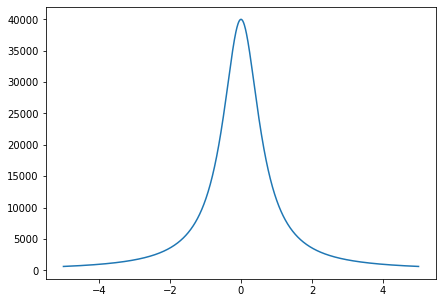

In [6]:
times = np.linspace(-5,5,1000)
vals = (1/4)*(1.25**2)/(np.power((times),2)+np.power(0.5*1.25,2))
plt.plot(times,40000*vals)

In [7]:
timestep=0.0001
max_count_rate=40000
FWHM = 1.25
center = 0
f_L = 0
def measure(f_L,time):
        counts = 0
        num_steps = int(time/timestep)
        for step in range(num_steps):
            #self.step()
            counts_per_second = max_count_rate*(1/4)*(FWHM**2)/(np.power((center-f_L),2)+np.power(0.5*FWHM,2))
            counts += counts_per_second*timestep
        counts += np.random.normal(loc=0.0, scale=np.sqrt(counts),size=1)
        return int(counts)

(array([  22.,  121.,  629., 1576., 2895., 2581., 1542.,  512.,  107.,
          15.]),
 array([187. , 198.5, 210. , 221.5, 233. , 244.5, 256. , 267.5, 279. ,
        290.5, 302. ]),
 <BarContainer object of 10 artists>)

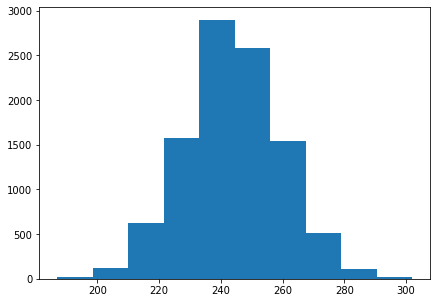

In [12]:
x = np.zeros(10000)
for i in range(10000):
    x[i] = measure(0.5,0.01)
plt.hist(x)

In [19]:
x_vals = np.linspace(-4,4,1000)
y_vals = 100*(1/4)*(1.25**2)/(np.power((x_vals),2)+np.power(0.5*1.25,2))

Text(0.5, 1.0, 'Quantum Dot Resonance Fluorescence')

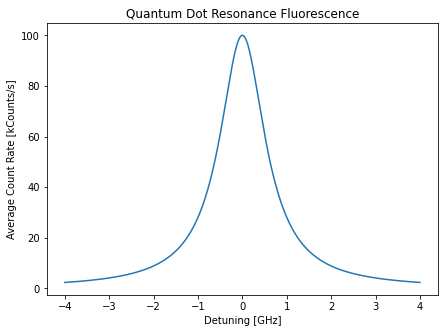

In [22]:
plt.plot(x_vals,y_vals)
plt.xlabel("Detuning [GHz]")
plt.ylabel("Average Count Rate [kCounts/s]")
plt.title("Quantum Dot Resonance Fluorescence")